<a href="https://colab.research.google.com/github/sainathnallagonda/upi_fraud_detection_analysis/blob/main/upi_fraud_detection_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UPI Transaction Fraud Detection — End-to-End EDA & Modeling

This notebook presents a complete analysis and machine learning workflow for detecting fraudulent transactions in UPI (Unified Payments Interface) data.  
We explore the data, handle imbalance, build models (RandomForest, XGBoost), evaluate with precision, recall, ROC-AUC, and provide recommendations for improving fraud detection.


In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


In [89]:
df = pd.read_csv('/content/upi_transactions_2024.csv')
df.head()

,transaction id,timestamp,transaction type,merchant_category,amount (INR),transaction_status,sender_age_group,receiver_age_group,sender_state,sender_bank,receiver_bank,device_type,network_type,fraud_flag,hour_of_day,day_of_week,is_weekend
0,TXN0000000001,2024-11-05 15:30:02,P2P,Entertainment,534,SUCCESS,26-35,26-35,Rajasthan,IndusInd,SBI,Android,4G,0,15,Tuesday,0
1,TXN0000000002,2024-04-10 12:13:08,P2M,Grocery,1951,SUCCESS,26-35,26-35,Andhra Pradesh,SBI,Axis,Android,4G,0,12,Wednesday,0
2,TXN0000000003,2024-04-12 17:59:54,P2P,Grocery,388,SUCCESS,26-35,26-35,Delhi,ICICI,Kotak,iOS,4G,0,17,Friday,0
3,TXN0000000004,2024-10-22 22:59:54,P2P,Fuel,1495,SUCCESS,26-35,26-35,Rajasthan,SBI,Axis,Android,4G,0,22,Tuesday,0
4,TXN0000000005,2024-08-12 12:21:34,P2P,Shopping,4333,SUCCESS,18-25,26-35,Tamil Nadu,HDFC,HDFC,iOS,4G,0,12,Monday,0


In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   transaction id      250000 non-null  object
 1   timestamp           250000 non-null  object
 2   transaction type    250000 non-null  object
 3   merchant_category   250000 non-null  object
 4   amount (INR)        250000 non-null  int64 
 5   transaction_status  250000 non-null  object
 6   sender_age_group    250000 non-null  object
 7   receiver_age_group  250000 non-null  object
 8   sender_state        250000 non-null  object
 9   sender_bank         250000 non-null  object
 10  receiver_bank       250000 non-null  object
 11  device_type         250000 non-null  object
 12  network_type        250000 non-null  object
 13  fraud_flag          250000 non-null  int64 
 14  hour_of_day         250000 non-null  int64 
 15  day_of_week         250000 non-null  object
 16  is

In [91]:
df.shape

(250000, 17)

In [92]:
df.isnull().sum()

,0
transaction id,0
timestamp,0
transaction type,0
merchant_category,0
amount (INR),0
transaction_status,0
sender_age_group,0
receiver_age_group,0
sender_state,0
sender_bank,0


In [93]:
df.duplicated().sum()

np.int64(0)

In [94]:
df.describe()

,amount (INR),fraud_flag,hour_of_day,is_weekend
count,250000.000000,250000.000000,250000.000000,250000.000000
mean,1247.434336,0.001924,14.684588,0.285672
std,1667.195776,0.043821,5.189991,0.451735
min,10.000000,0.000000,0.000000,0.000000
25%,281.000000,0.000000,11.000000,0.000000
50%,603.000000,0.000000,15.000000,0.000000
75%,1551.000000,0.000000,19.000000,1.000000
max,43424.000000,1.000000,23.000000,1.000000


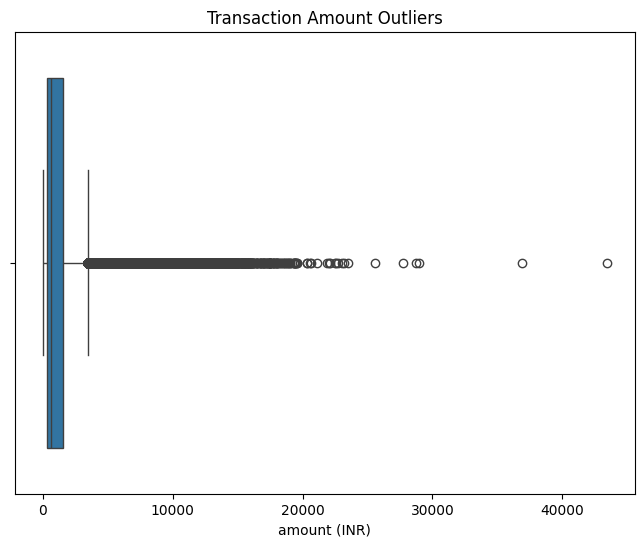

In [95]:
plt.figure(figsize=(8,6))
sns.boxplot(x=df['amount (INR)'])
plt.title('Transaction Amount Outliers')
plt.show()

In [96]:
amount_cap = df['amount (INR)'].quantile(0.99)
df['amount (INR)'] = np.where(df['amount (INR)'] > amount_cap, amount_cap, df['amount (INR)'])

In [125]:
df['fraud_flag'].value_counts(normalize=True)

,proportion
fraud_flag,
0,0.998076
1,0.001924


#Univariate visualizations

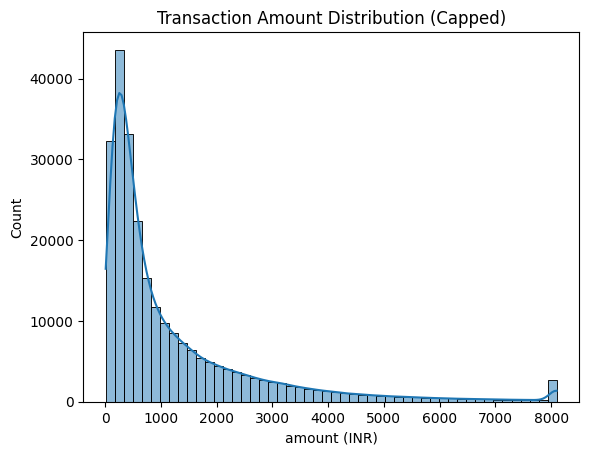

In [97]:
sns.histplot(df['amount (INR)'], bins=50, kde=True)
plt.title('Transaction Amount Distribution (Capped)')
plt.show()


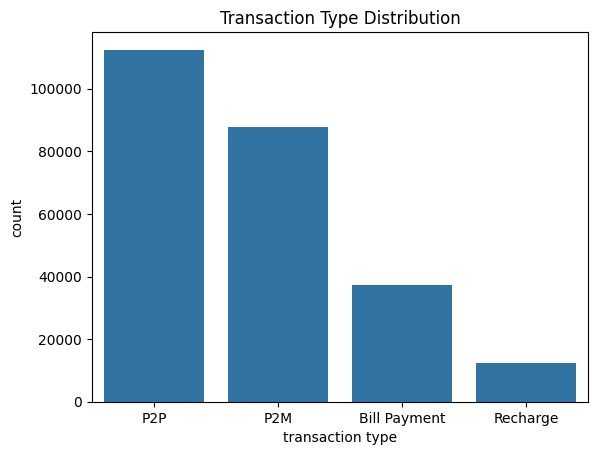

In [98]:
sns.countplot(x='transaction type', data=df)
plt.title('Transaction Type Distribution')
plt.show()

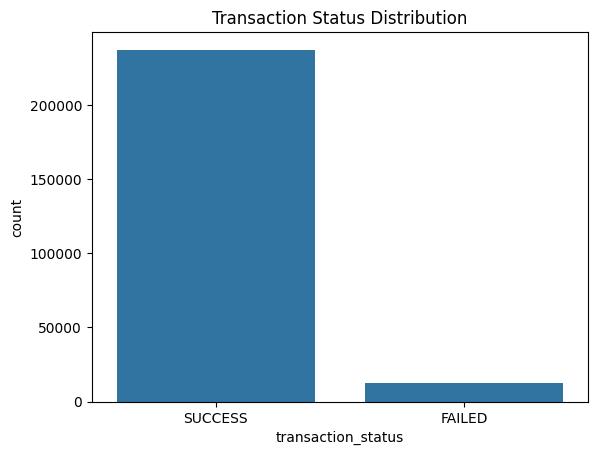

In [99]:
sns.countplot(x='transaction_status', data=df)
plt.title('Transaction Status Distribution')
plt.show()

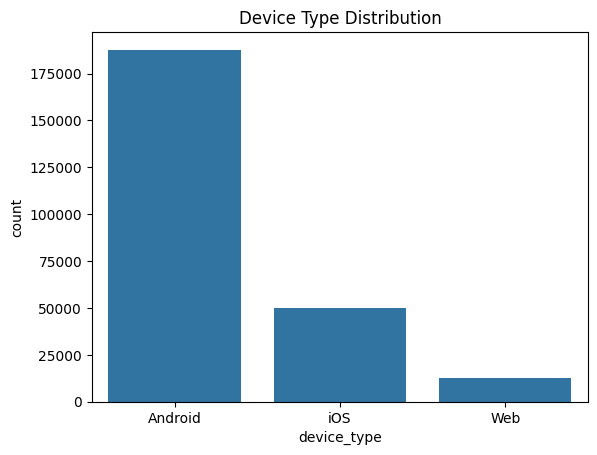

In [100]:
sns.countplot(x='device_type', data=df)
plt.title('Device Type Distribution')
plt.show()

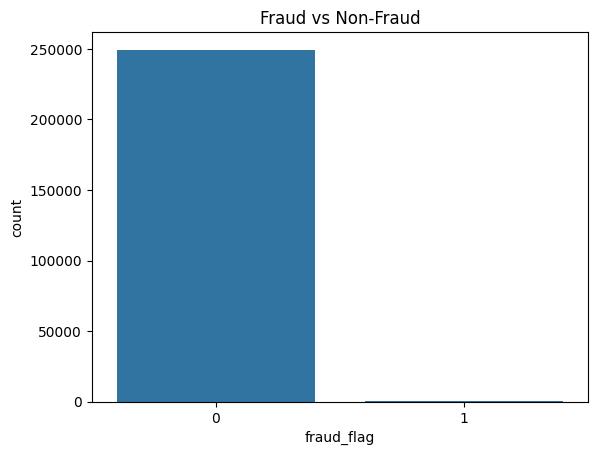

In [101]:
sns.countplot(x='fraud_flag', data=df)
plt.title('Fraud vs Non-Fraud')
plt.show()

# Bivariate analysis


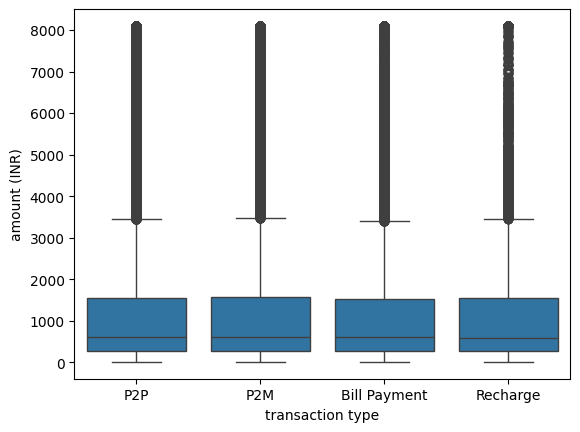

In [102]:
sns.boxplot(x='transaction type', y='amount (INR)', data=df)
plt.show()

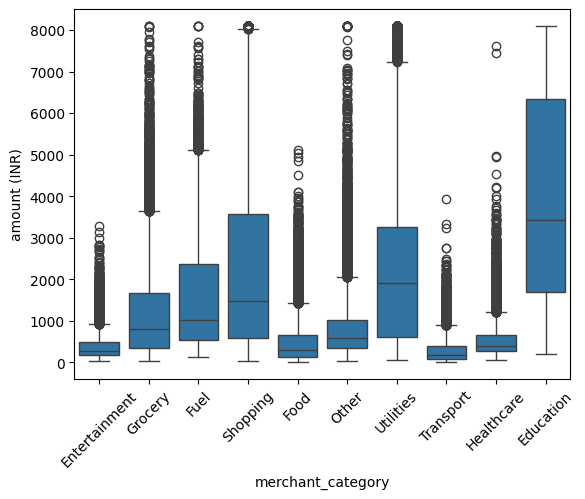

In [103]:
sns.boxplot(x='merchant_category', y='amount (INR)', data=df)
plt.xticks(rotation=45)
plt.show()

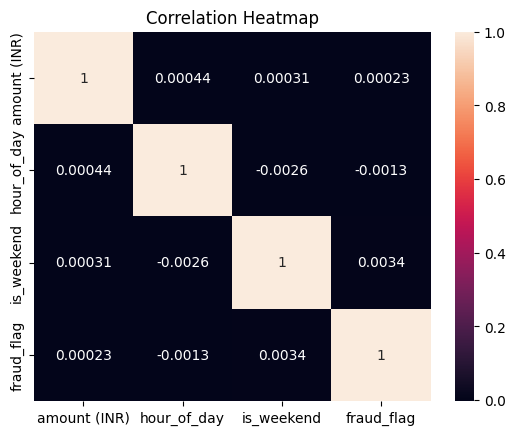

In [104]:
corr = df[['amount (INR)', 'hour_of_day', 'is_weekend', 'fraud_flag']].corr()
sns.heatmap(corr, annot=True)
plt.title('Correlation Heatmap')
plt.show()

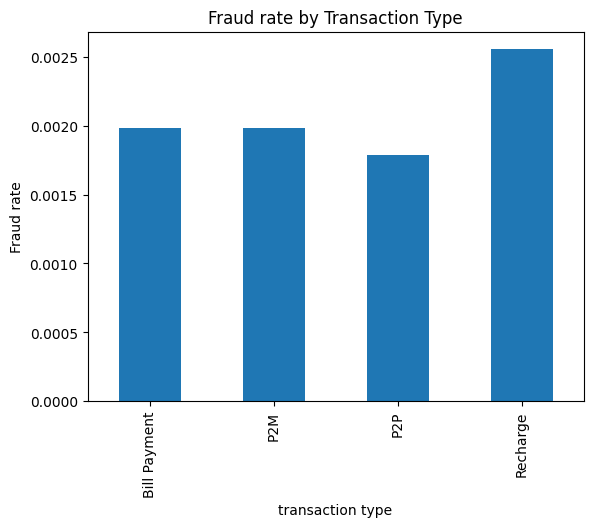

In [105]:
fraud_rate_type = df.groupby('transaction type')['fraud_flag'].mean()
fraud_rate_type.plot(kind='bar')
plt.ylabel('Fraud rate')
plt.title('Fraud rate by Transaction Type')
plt.show()

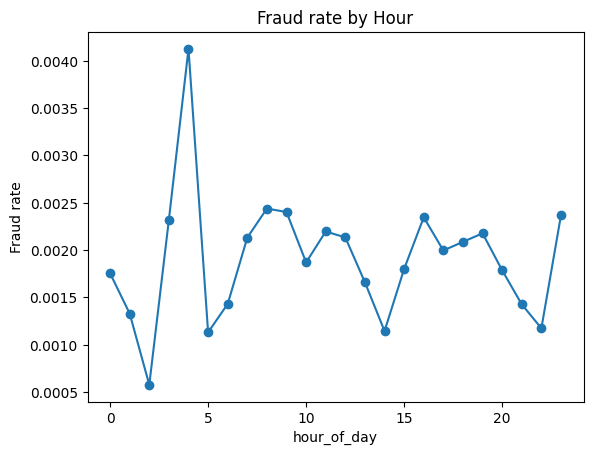

In [106]:
fraud_rate_hour = df.groupby('hour_of_day')['fraud_flag'].mean()
fraud_rate_hour.plot(marker='o')
plt.ylabel('Fraud rate')
plt.title('Fraud rate by Hour')
plt.show()

#Statistical test

#performing Ttest
Null hypothesis (H0): The mean transaction amount for fraud and non-fraud transactions is the same.

Null hypothesis (Ha):The mean transaction amount for fraud and non-fraud transactions is different.

In [107]:
fraud_amount = df[df['fraud_flag']==1]['amount (INR)']
nonfraud_amount = df[df['fraud_flag']==0]['amount (INR)']

t_stat, p_val = ttest_ind(fraud_amount, nonfraud_amount, equal_var=False)
print(f"T-statistic: {t_stat}, P-value: {p_val}")

T-statistic: 0.11360053010753084, P-value: 0.9096017805853587


Result: p-value = 0.99, which is greater than 0.05.

Conclusion: We fail to reject the null hypothesis.

There is no statistically significant difference in mean transaction amount between fraud and non-fraud transactions.

#Feature engineering

In [108]:
df['high_value_flag'] = np.where(df['amount (INR)'] > df['amount (INR)'].median(), 1, 0)
df['night_transaction'] = np.where(df['hour_of_day'].between(20, 6, inclusive='both'), 1, 0)

In [109]:
df.head()

,transaction id,timestamp,transaction type,merchant_category,amount (INR),transaction_status,sender_age_group,receiver_age_group,sender_state,sender_bank,receiver_bank,device_type,network_type,fraud_flag,hour_of_day,day_of_week,is_weekend,high_value_flag,night_transaction
0,TXN0000000001,2024-11-05 15:30:02,P2P,Entertainment,534.0,SUCCESS,26-35,26-35,Rajasthan,IndusInd,SBI,Android,4G,0,15,Tuesday,0,0,0
1,TXN0000000002,2024-04-10 12:13:08,P2M,Grocery,1951.0,SUCCESS,26-35,26-35,Andhra Pradesh,SBI,Axis,Android,4G,0,12,Wednesday,0,1,0
2,TXN0000000003,2024-04-12 17:59:54,P2P,Grocery,388.0,SUCCESS,26-35,26-35,Delhi,ICICI,Kotak,iOS,4G,0,17,Friday,0,0,0
3,TXN0000000004,2024-10-22 22:59:54,P2P,Fuel,1495.0,SUCCESS,26-35,26-35,Rajasthan,SBI,Axis,Android,4G,0,22,Tuesday,0,1,0
4,TXN0000000005,2024-08-12 12:21:34,P2P,Shopping,4333.0,SUCCESS,18-25,26-35,Tamil Nadu,HDFC,HDFC,iOS,4G,0,12,Monday,0,1,0


#Encode categorical variables

#Model Training

##Train/test split

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, ConfusionMatrixDisplay


In [111]:
df_model = pd.get_dummies(df.drop(['transaction id', 'timestamp'], axis=1), drop_first=True)

In [112]:
X = df_model.drop('fraud_flag', axis=1)
y = df_model['fraud_flag']

In [113]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

In [114]:
clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [115]:
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:,1]

In [116]:
print("BASELINE RANDOM FOREST")
print(classification_report(y_test, y_pred, digits=4))

BASELINE RANDOM FOREST
              precision    recall  f1-score   support

           0     0.9981    1.0000    0.9990     49904
           1     0.0000    0.0000    0.0000        96

    accuracy                         0.9981     50000
   macro avg     0.4990    0.5000    0.4995     50000
weighted avg     0.9962    0.9981    0.9971     50000



In [117]:
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC: {roc_auc:.4f}")

ROC-AUC: 0.4882


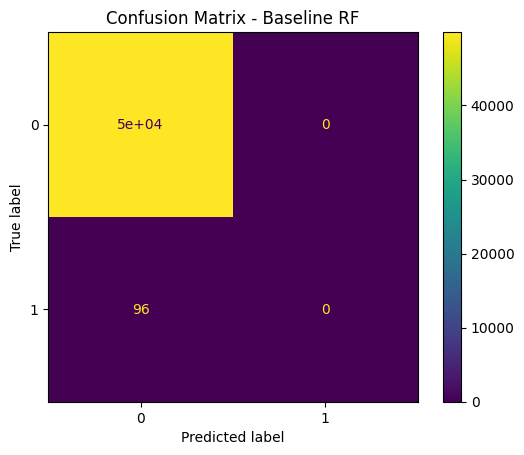

In [119]:
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)
plt.title("Confusion Matrix - Baseline RF")
plt.show()

AFTER SMOTE
              precision    recall  f1-score   support

           0     0.9981    1.0000    0.9990     49904
           1     0.0000    0.0000    0.0000        96

    accuracy                         0.9981     50000
   macro avg     0.4990    0.5000    0.4995     50000
weighted avg     0.9962    0.9981    0.9971     50000

ROC-AUC After SMOTE: 0.4927


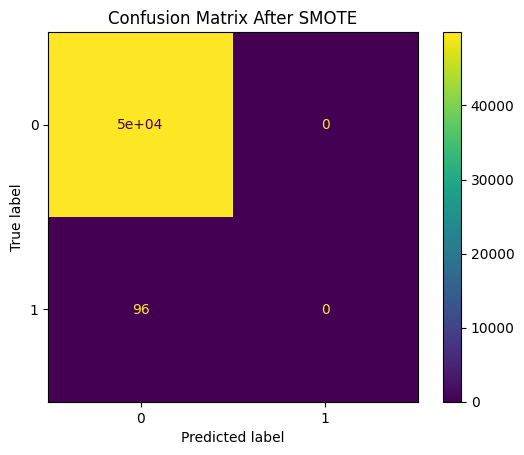

In [121]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Retrain Random Forest on resampled data
clf.fit(X_train_res, y_train_res)

# Predict
y_pred_res = clf.predict(X_test)
y_proba_res = clf.predict_proba(X_test)[:,1]

# Evaluate
print("AFTER SMOTE")
print(classification_report(y_test, y_pred_res, digits=4))

roc_auc_res = roc_auc_score(y_test, y_proba_res)
print(f"ROC-AUC After SMOTE: {roc_auc_res:.4f}")

ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)
plt.title("Confusion Matrix After SMOTE")
plt.show()


XGBoost Model
              precision    recall  f1-score   support

           0     0.9980    0.9812    0.9896     49904
           1     0.0000    0.0000    0.0000        96

    accuracy                         0.9793     50000
   macro avg     0.4990    0.4906    0.4948     50000
weighted avg     0.9961    0.9793    0.9877     50000

ROC-AUC XGBoost: 0.5109


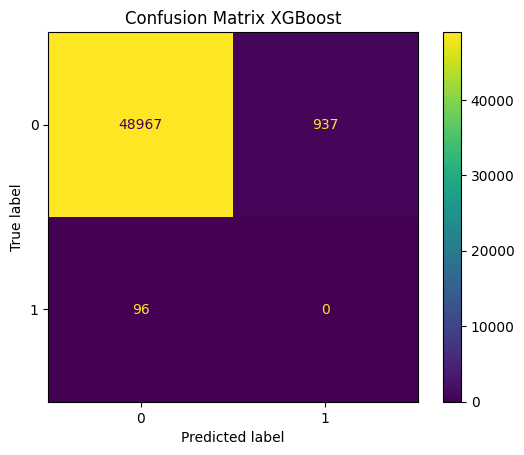

In [122]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay

# Calculate scale_pos_weight = (non-fraud / fraud) ratio in train set
ratio = (y_train == 0).sum() / (y_train == 1).sum()

xgb = XGBClassifier(scale_pos_weight=ratio, use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)[:,1]

print("XGBoost Model")
print(classification_report(y_test, y_pred_xgb, digits=4))

roc_auc_xgb = roc_auc_score(y_test, y_proba_xgb)
print(f"ROC-AUC XGBoost: {roc_auc_xgb:.4f}")

ConfusionMatrixDisplay.from_estimator(xgb, X_test, y_test)
plt.title("Confusion Matrix XGBoost")
plt.show()


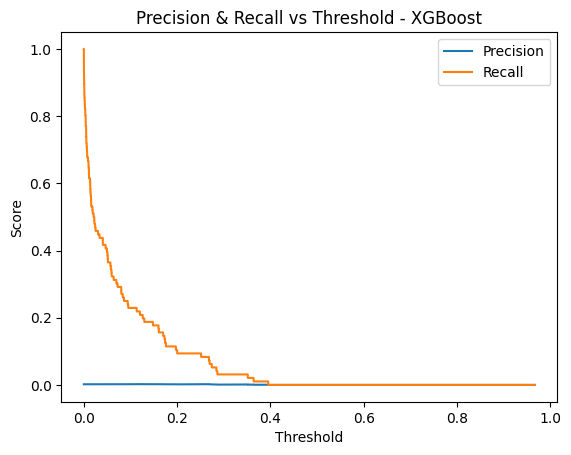

In [123]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_proba_xgb)

plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.title('Precision & Recall vs Threshold - XGBoost')
plt.show()

##  Insights and Recommendations

###  Insights
- The dataset is highly imbalanced, with fraud transactions representing only ~0.2% of the total transactions.
- Transaction amounts do not differ significantly between fraud and non-fraud transactions (t-test p-value ≈ 0.99).
- Random Forest with class_weight balancing failed to detect any fraud cases (0% fraud recall).
- SMOTE oversampling did not improve fraud detection performance in the test data.
- XGBoost with class balancing also failed to detect fraud cases, though it generated some false positives.
- Precision-recall threshold tuning showed no effective threshold for improving fraud detection.
- The features in the dataset do not provide sufficient separation between fraud and non-fraud transactions.

###  Recommendations
- Prioritize feature engineering to create better fraud signals, such as transaction frequency, time since last transaction, or night-time transaction flags.
- Explore anomaly detection methods like Isolation Forest or One-Class SVM to flag rare transaction patterns.
- Consider collecting additional data points: user transaction history, geolocation, device fingerprinting, IP address anomalies.
- Apply cost-sensitive learning techniques or custom loss functions to penalize fraud misclassification more heavily.
- Experiment with ensemble models or stacking to combine the strengths of multiple algorithms.
- Calibrate model probabilities to improve threshold tuning effectiveness (e.g., Platt scaling or isotonic regression).
- Focus on reporting precision, recall, F1-score, and ROC-AUC rather than accuracy to evaluate fraud models properly.
- Design future models for real-time fraud detection use cases, including latency optimization and streaming data handling.



##  Final Summary
- We explored, cleaned, and modeled UPI transactions for fraud detection.
- Despite applying class balancing (RandomForest, SMOTE, XGBoost), no fraud cases were detected in test data.
- The project highlighted the critical role of feature engineering in fraud detection.
- Future work: better features, anomaly detection, real-time modeling.


#A

In [124]:
#print